In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

2024-04-25 05:09:08.957264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 05:09:10.806524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-04-25 05:09:10.806662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
# data
dataset_name = "mnist"
dataset_repetitions = 1
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 32
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:

def preprocess_image(data):
    # center crop image
    # height = ops.shape(data["image"])[0]
    # width = ops.shape(data["image"])[1]
    # crop_size = ops.minimum(height, width)
    # image = tf.image.crop_to_bounding_box(
    #     data["image"],
    #     (height - crop_size) // 2,
    #     (width - crop_size) // 2,
    #     crop_size,
    #     crop_size,
    # )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.grayscale_to_rgb(data["image"])
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train")
val_dataset = prepare_dataset("test")

2024-04-25 05:09:15.665485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 05:09:16.408153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [4]:

@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [5]:

@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


In [6]:

@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


In [11]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
# model.compile(
#     optimizer=keras.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     ),
#     loss=keras.losses.mean_absolute_error,
# )
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
# checkpoint_path = "checkpoints/diffusion_model.weights.h5"

# model.load_weights(checkpoint_path)


# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=True,
#     monitor="val_kid",
#     mode="min",
#     save_best_only=True,
# )

# calculate mean and variance of training dataset for normalization
# model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
# model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=val_dataset,
#     callbacks=[
#         keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
#         checkpoint_callback,
#     ],
# )

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'residual_unet', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 1, 1, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_9'}, 'registered_name': None, 'name': 'input_layer_9', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 32, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_8'}, 'registered_name': None, 'name': 'input_layer_8', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_4', 'trainable': True, 'dtype': 'float32', 'function': <function sinusoidal_embedding at 0x15303e294700>, 'output_shape': [1, 1, 32], 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': (None, 1, 1, 1)}, 'name': 'lambda_4', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 1, 1, 1), 'dtype': 'float32', 'keras_history': ['input_layer_9', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_160', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 3)}, 'name': 'conv2d_160', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 3), 'dtype': 'float32', 'keras_history': ['input_layer_8', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_16', 'trainable': True, 'dtype': 'float32', 'size': (32, 32), 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': (None, 1, 1, 32)}, 'name': 'up_sampling2d_16', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 1, 1, 32), 'dtype': 'float32', 'keras_history': ['lambda_4', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_28', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 32), (None, 32, 32, 32)]}, 'name': 'concatenate_28', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_160', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['up_sampling2d_16', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_56', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 64)}, 'name': 'batch_normalization_56', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['concatenate_28', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_162', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 64)}, 'name': 'conv2d_162', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['batch_normalization_56', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_163', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'conv2d_163', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_162', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_161', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 64)}, 'name': 'conv2d_161', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['concatenate_28', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_56', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 32), (None, 32, 32, 32)]}, 'name': 'add_56', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_163', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_161', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_57', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'batch_normalization_57', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_56', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_164', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'conv2d_164', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['batch_normalization_57', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_165', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'conv2d_165', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_164', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_57', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 32), (None, 32, 32, 32)]}, 'name': 'add_57', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_165', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_56', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_12', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'average_pooling2d_12', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_57', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_58', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 32)}, 'name': 'batch_normalization_58', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 32), 'dtype': 'float32', 'keras_history': ['average_pooling2d_12', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_167', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 32)}, 'name': 'conv2d_167', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 32), 'dtype': 'float32', 'keras_history': ['batch_normalization_58', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_168', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'conv2d_168', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_167', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_166', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 32)}, 'name': 'conv2d_166', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 32), 'dtype': 'float32', 'keras_history': ['average_pooling2d_12', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_58', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 16, 16, 64), (None, 16, 16, 64)]}, 'name': 'add_58', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_168', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_166', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_59', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'batch_normalization_59', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_58', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_169', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'conv2d_169', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['batch_normalization_59', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_170', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'conv2d_170', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_169', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_59', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 16, 16, 64), (None, 16, 16, 64)]}, 'name': 'add_59', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_170', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_58', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_13', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'average_pooling2d_13', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_59', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_60', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 64)}, 'name': 'batch_normalization_60', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 64), 'dtype': 'float32', 'keras_history': ['average_pooling2d_13', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_172', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 64)}, 'name': 'conv2d_172', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 64), 'dtype': 'float32', 'keras_history': ['batch_normalization_60', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_173', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'conv2d_173', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_172', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_171', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 64)}, 'name': 'conv2d_171', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 64), 'dtype': 'float32', 'keras_history': ['average_pooling2d_13', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_60', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 8, 8, 96), (None, 8, 8, 96)]}, 'name': 'add_60', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_173', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_171', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_61', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'batch_normalization_61', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_60', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_174', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'conv2d_174', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['batch_normalization_61', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_175', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'conv2d_175', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_174', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_61', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 8, 8, 96), (None, 8, 8, 96)]}, 'name': 'add_61', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_175', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_60', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_14', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'average_pooling2d_14', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_61', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_62', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 96)}, 'name': 'batch_normalization_62', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 96), 'dtype': 'float32', 'keras_history': ['average_pooling2d_14', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_177', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 96)}, 'name': 'conv2d_177', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 96), 'dtype': 'float32', 'keras_history': ['batch_normalization_62', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_178', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 128)}, 'name': 'conv2d_178', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['conv2d_177', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_176', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 96)}, 'name': 'conv2d_176', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 96), 'dtype': 'float32', 'keras_history': ['average_pooling2d_14', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_62', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 4, 4, 128), (None, 4, 4, 128)]}, 'name': 'add_62', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['conv2d_178', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['conv2d_176', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_63', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 128)}, 'name': 'batch_normalization_63', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['add_62', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_179', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 128)}, 'name': 'conv2d_179', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['batch_normalization_63', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_180', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 128)}, 'name': 'conv2d_180', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['conv2d_179', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_63', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 4, 4, 128), (None, 4, 4, 128)]}, 'name': 'add_63', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['conv2d_180', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['add_62', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_17', 'trainable': True, 'dtype': 'float32', 'size': (2, 2), 'data_format': 'channels_last', 'interpolation': 'bilinear'}, 'registered_name': None, 'build_config': {'input_shape': (None, 4, 4, 128)}, 'name': 'up_sampling2d_17', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 4, 128), 'dtype': 'float32', 'keras_history': ['add_63', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_29', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 8, 8, 128), (None, 8, 8, 96)]}, 'name': 'concatenate_29', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 128), 'dtype': 'float32', 'keras_history': ['up_sampling2d_17', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_61', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_64', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 224)}, 'name': 'batch_normalization_64', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 224), 'dtype': 'float32', 'keras_history': ['concatenate_29', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_182', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 224)}, 'name': 'conv2d_182', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 224), 'dtype': 'float32', 'keras_history': ['batch_normalization_64', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_183', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'conv2d_183', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_182', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_181', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 224)}, 'name': 'conv2d_181', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 224), 'dtype': 'float32', 'keras_history': ['concatenate_29', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_64', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 8, 8, 96), (None, 8, 8, 96)]}, 'name': 'add_64', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_183', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_181', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_30', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 8, 8, 96), (None, 8, 8, 96)]}, 'name': 'concatenate_30', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_64', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_60', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_65', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 192)}, 'name': 'batch_normalization_65', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 192), 'dtype': 'float32', 'keras_history': ['concatenate_30', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_185', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 192)}, 'name': 'conv2d_185', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 192), 'dtype': 'float32', 'keras_history': ['batch_normalization_65', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_186', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'conv2d_186', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_185', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_184', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 192)}, 'name': 'conv2d_184', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 192), 'dtype': 'float32', 'keras_history': ['concatenate_30', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_65', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 8, 8, 96), (None, 8, 8, 96)]}, 'name': 'add_65', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_186', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['conv2d_184', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_18', 'trainable': True, 'dtype': 'float32', 'size': (2, 2), 'data_format': 'channels_last', 'interpolation': 'bilinear'}, 'registered_name': None, 'build_config': {'input_shape': (None, 8, 8, 96)}, 'name': 'up_sampling2d_18', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 8, 8, 96), 'dtype': 'float32', 'keras_history': ['add_65', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_31', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 16, 16, 96), (None, 16, 16, 64)]}, 'name': 'concatenate_31', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 96), 'dtype': 'float32', 'keras_history': ['up_sampling2d_18', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_59', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_66', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 160)}, 'name': 'batch_normalization_66', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 160), 'dtype': 'float32', 'keras_history': ['concatenate_31', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_188', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 160)}, 'name': 'conv2d_188', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 160), 'dtype': 'float32', 'keras_history': ['batch_normalization_66', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_189', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'conv2d_189', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_188', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_187', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 160)}, 'name': 'conv2d_187', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 160), 'dtype': 'float32', 'keras_history': ['concatenate_31', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_66', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 16, 16, 64), (None, 16, 16, 64)]}, 'name': 'add_66', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_189', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_187', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_32', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 16, 16, 64), (None, 16, 16, 64)]}, 'name': 'concatenate_32', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_66', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_58', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_67', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 128)}, 'name': 'batch_normalization_67', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 128), 'dtype': 'float32', 'keras_history': ['concatenate_32', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_191', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 128)}, 'name': 'conv2d_191', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 128), 'dtype': 'float32', 'keras_history': ['batch_normalization_67', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_192', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'conv2d_192', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_191', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_190', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 128)}, 'name': 'conv2d_190', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 128), 'dtype': 'float32', 'keras_history': ['concatenate_32', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_67', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 16, 16, 64), (None, 16, 16, 64)]}, 'name': 'add_67', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_192', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['conv2d_190', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_19', 'trainable': True, 'dtype': 'float32', 'size': (2, 2), 'data_format': 'channels_last', 'interpolation': 'bilinear'}, 'registered_name': None, 'build_config': {'input_shape': (None, 16, 16, 64)}, 'name': 'up_sampling2d_19', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 16, 16, 64), 'dtype': 'float32', 'keras_history': ['add_67', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_33', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 64), (None, 32, 32, 32)]}, 'name': 'concatenate_33', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['up_sampling2d_19', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_57', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_68', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 96)}, 'name': 'batch_normalization_68', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 96), 'dtype': 'float32', 'keras_history': ['concatenate_33', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_194', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 96)}, 'name': 'conv2d_194', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 96), 'dtype': 'float32', 'keras_history': ['batch_normalization_68', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_195', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'conv2d_195', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_194', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_193', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 96)}, 'name': 'conv2d_193', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 96), 'dtype': 'float32', 'keras_history': ['concatenate_33', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_68', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 32), (None, 32, 32, 32)]}, 'name': 'add_68', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_195', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_193', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_34', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 32), (None, 32, 32, 32)]}, 'name': 'concatenate_34', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_68', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_56', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_69', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': False, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 64)}, 'name': 'batch_normalization_69', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['concatenate_34', 0, 0]}},), 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_197', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 64)}, 'name': 'conv2d_197', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['batch_normalization_69', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_198', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'conv2d_198', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_197', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_196', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 64)}, 'name': 'conv2d_196', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 64), 'dtype': 'float32', 'keras_history': ['concatenate_34', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_69', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [(None, 32, 32, 32), (None, 32, 32, 32)]}, 'name': 'add_69', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_198', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['conv2d_196', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_199', 'trainable': True, 'dtype': 'float32', 'filters': 3, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 32)}, 'name': 'conv2d_199', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 32, 32), 'dtype': 'float32', 'keras_history': ['add_69', 0, 0]}},), 'kwargs': {}}]}], 'input_layers': [['input_layer_8', 0, 0], ['input_layer_9', 0, 0]], 'output_layers': [['conv2d_199', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}}.

Exception encountered: Exception encountered when calling Lambda.call().

[1mcan only concatenate tuple (not "TrackedList") to tuple[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 1, 1, 1), dtype=float32, sparse=False, name=input_layer_9>',)
  • kwargs={'mask': 'None'}

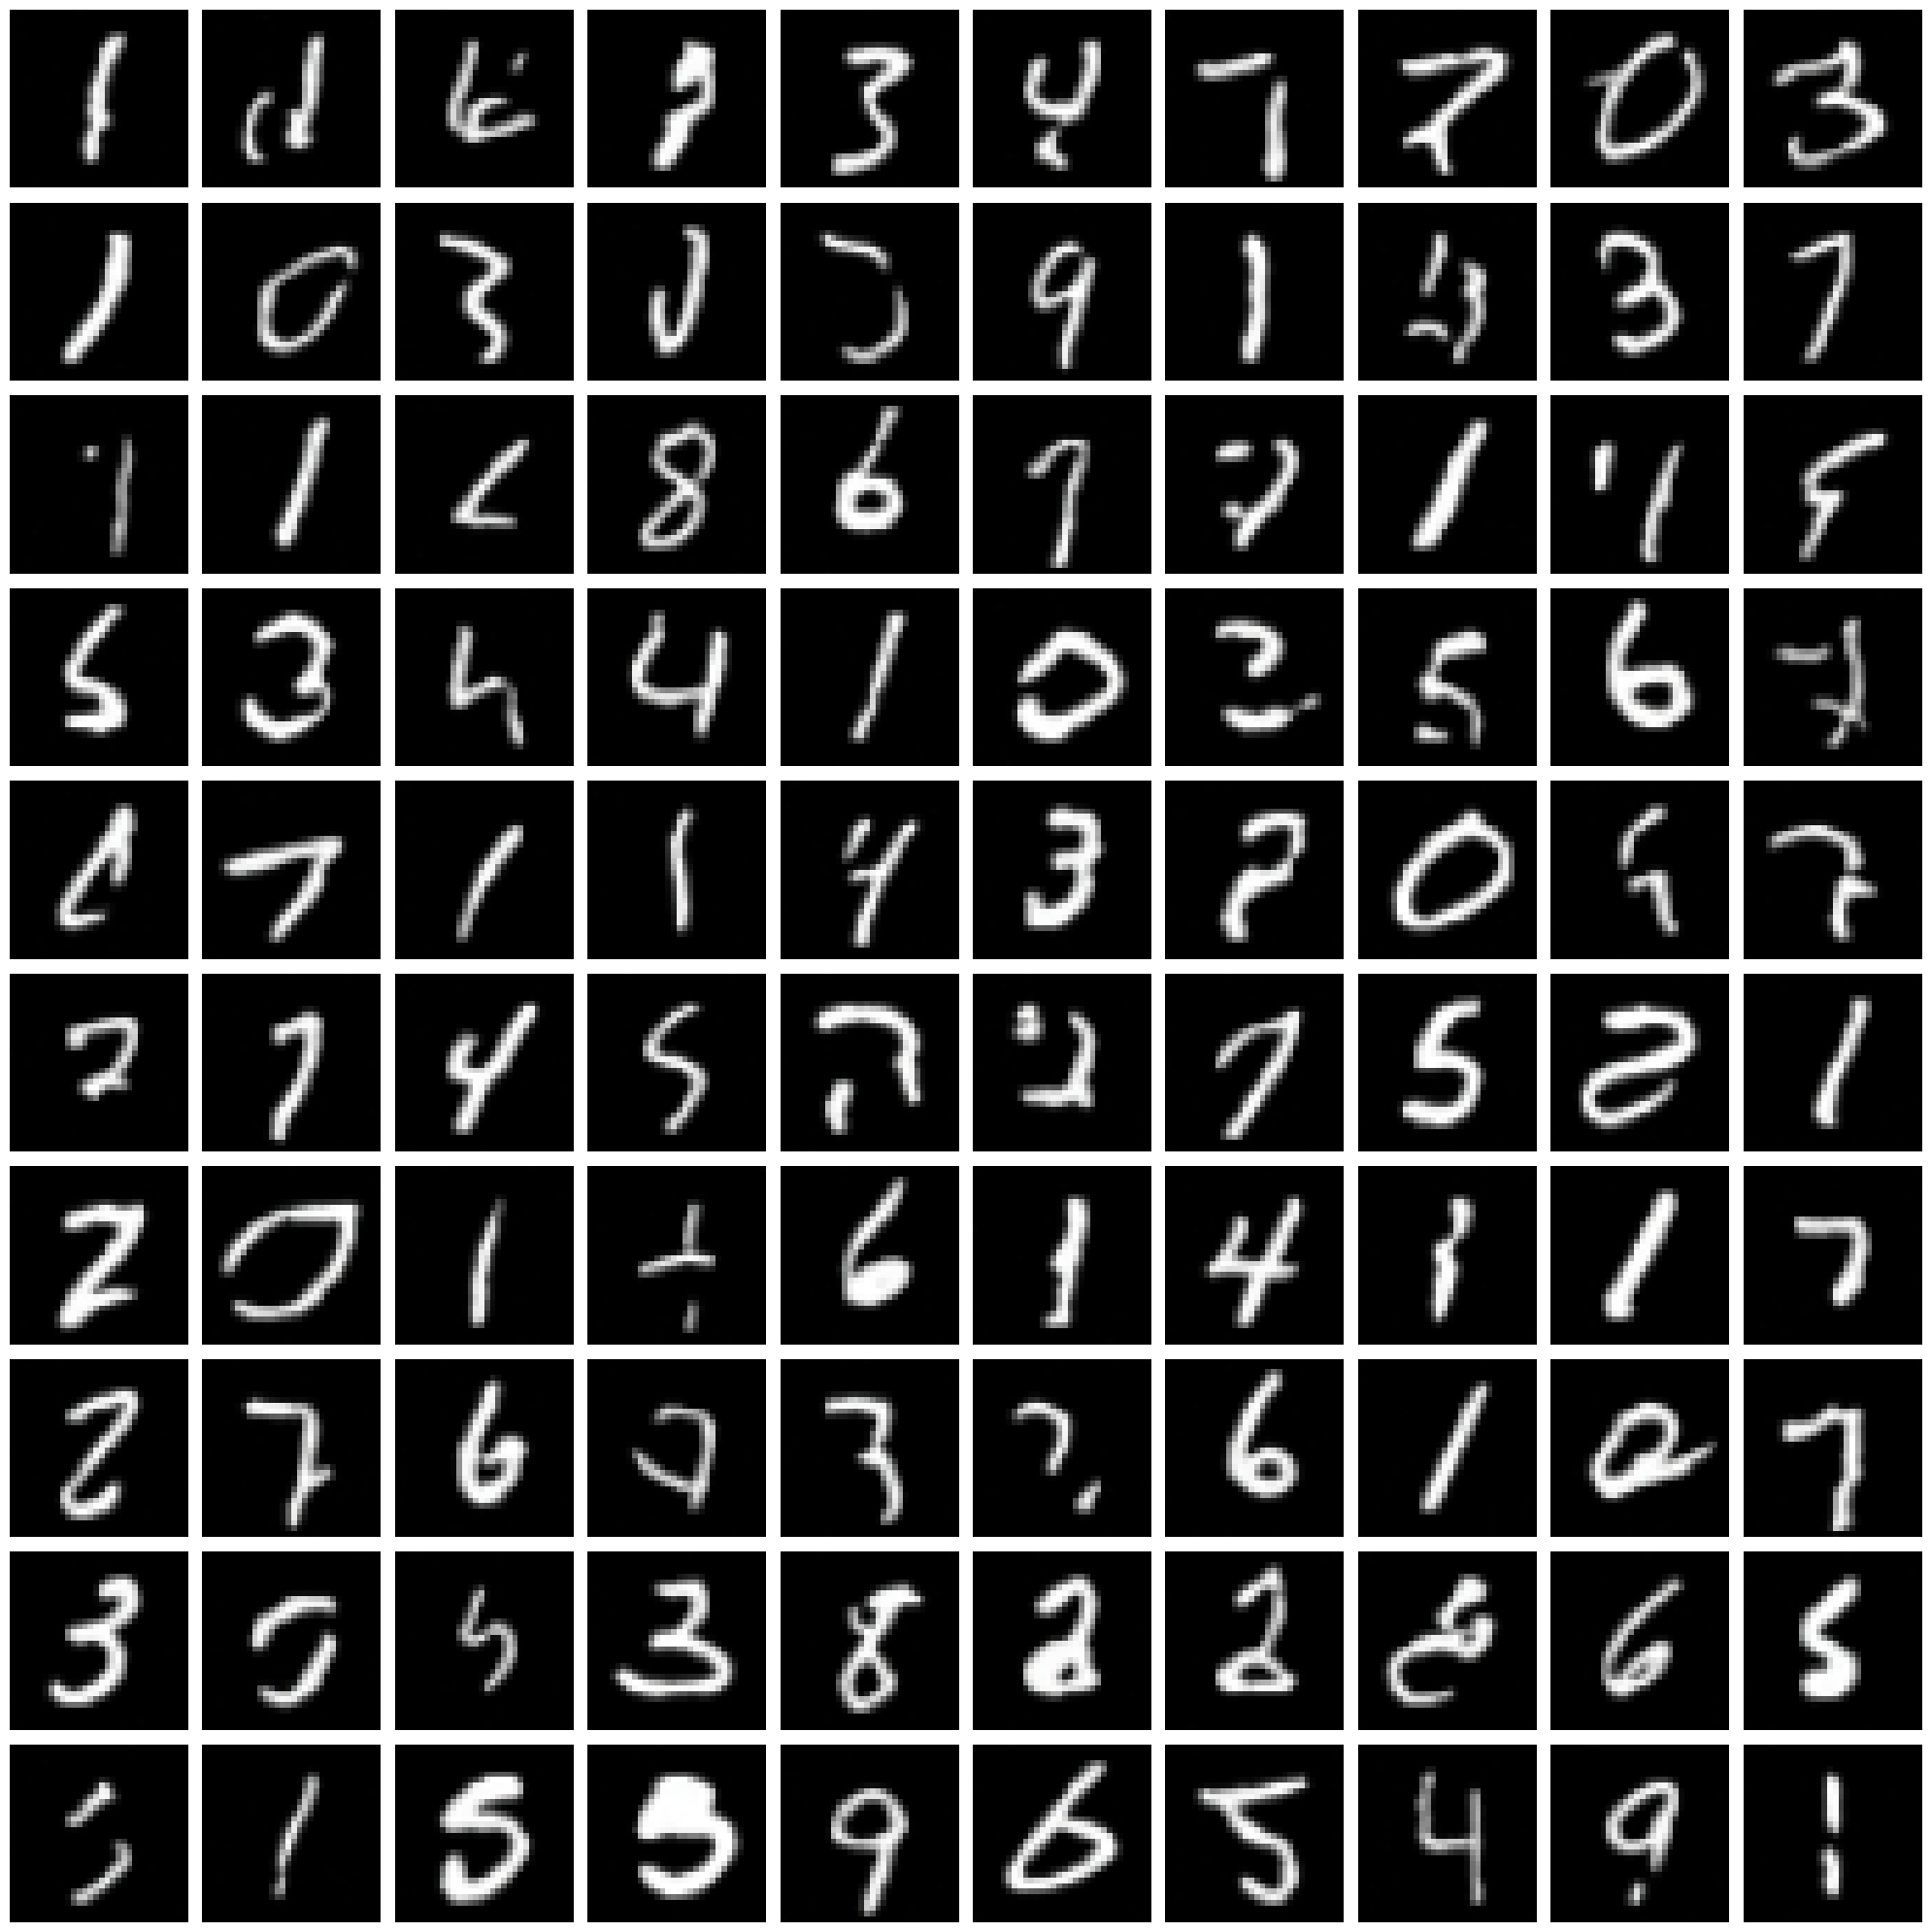

In [20]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images(num_rows=10, num_cols=10)

2024-03-09 11:15:58.311139: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-09 11:15:58.311322: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


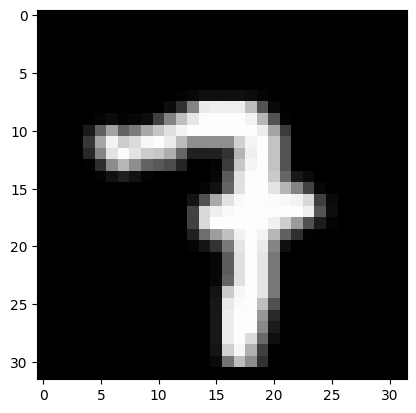

In [15]:
tst = (train_dataset.take(1))
for d in tst:
    # print(d[0])
    plt.imshow(d[0])
    break